In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LinearRegression").getOrCreate()

file_path = '/content/drive/MyDrive/bamsisdata/auto-mpg.csv'
data = spark.read.csv(file_path, header=True, inferSchema=True)

data.show(5)
data.printSchema()

+----+---------+------------+----------+------+------------+----------+------+--------------------+
| mpg|cylinders|displacement|horsepower|weight|acceleration|model year|origin|            car name|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
|18.0|        8|       307.0|       130|  3504|        12.0|        70|     1|chevrolet chevell...|
|15.0|        8|       350.0|       165|  3693|        11.5|        70|     1|   buick skylark 320|
|18.0|        8|       318.0|       150|  3436|        11.0|        70|     1|  plymouth satellite|
|16.0|        8|       304.0|       150|  3433|        12.0|        70|     1|       amc rebel sst|
|17.0|        8|       302.0|       140|  3449|        10.5|        70|     1|         ford torino|
+----+---------+------------+----------+------+------------+----------+------+--------------------+
only showing top 5 rows

root
 |-- mpg: double (nullable = true)
 |-- cylinders: integer (nullable =

In [23]:
data = data.select('cylinders', 'weight', 'acceleration', 'mpg')
data = data.dropna()


In [24]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['cylinders', 'weight', 'acceleration'], outputCol='features')
data = assembler.transform(data)


In [25]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [26]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='mpg')
lr_model = lr.fit(train_data)

print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")


Coefficients: [-0.348950210223931,-0.006705900116562101,0.13668911326412753]
Intercept: 43.207431594412135


In [27]:
predictions = lr_model.transform(test_data)
evaluator_mae = RegressionEvaluator(labelCol="mpg", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 3.256014512203146


In [28]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol='mpg', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 17.563286533704385


In [29]:
evaluator_r2 = RegressionEvaluator(labelCol="mpg", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared (R²): {r2}")

R-squared (R²): 0.7478651808025663


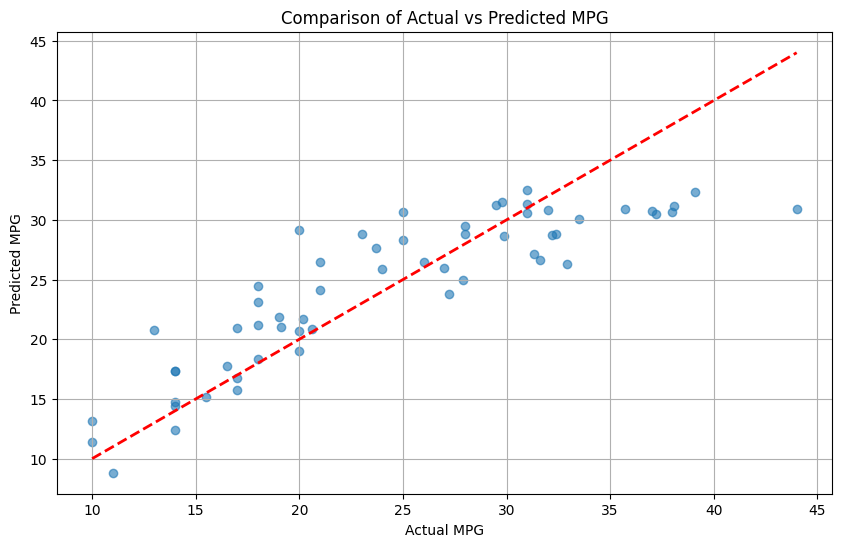

In [30]:
import matplotlib.pyplot as plt

predictions_pandas = predictions.select('mpg', 'prediction').toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas['mpg'], predictions_pandas['prediction'], alpha=0.6)
plt.plot([predictions_pandas['mpg'].min(), predictions_pandas['mpg'].max()],
         [predictions_pandas['mpg'].min(), predictions_pandas['mpg'].max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Comparison of Actual vs Predicted MPG')
plt.grid()
plt.show()


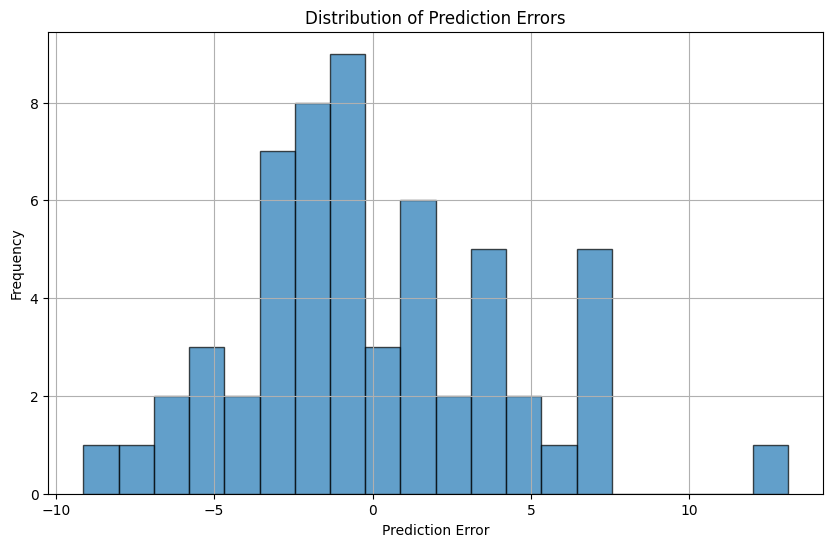

In [31]:
predictions_pandas['error'] = predictions_pandas['mpg'] - predictions_pandas['prediction']

plt.figure(figsize=(10, 6))
plt.hist(predictions_pandas['error'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid()
plt.show()
